In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [22]:
#We first define a utility function that takes a list of graphs and produces
#a list of graphs which represent the distinct isomorphism classes of the given list of graphs
#one can take note that it is defined recursively and is computationally expensive due to the
#is_isomorphic function

#takes a list of graphs L and an empty array E.  The array E will eventually be returned when the unique graphs under graph isomorphism is built
def graphs_to_reps(L, E):
    if len(L) == 0:
        return E
    S = L.copy()
    s = len(S)
    for i in range(0,s-1):
        #if the last element of the array is isomorphic to any of the graphs before it, then pop it off and call the function with the shorter list S
        if nx.is_isomorphic(S[i], S[-1]):
            #diagnostic print(f"Popping off the graph {str(S[i])} because {str(S[i])} is isomorphic to {str(S[-1])}.")
            G = S.pop()
            return graphs_to_reps(S,E)
        #if this point is reached, it means the last element is a representative of an isomorphism class distinct from any others already represented
        #so we can safely place it in our array of distinct representatives E
    G = S.pop()
    #diagnostic print(f"Popping off the graph {str(G)} and adding it to the list of unique representatives.")
    E.append(G)
    #now we have reduced the length of S by 1 in this case as well, so we can call the function again on the shorter array.
    #E is behaving as storage across function calls.
    return graphs_to_reps(S,E)

#here is another utility function which takes a graph G and produces a list of the (not necessarily distinct) edge deleted subgraphs of g

def edge_deleted_subgraphs(G):
    L = []
    for e in G.edges():
        H = G.copy()
        H.remove_edge(e[0],e[1])
        L.append(H)
    return L

#uncomment the following code for an example use of the above two functions and the effect of their combination
"""
G = nx.petersen_graph()

L1 = edge_deleted_subgraphs(G)

L = graphs_to_reps(edge_deleted_subgraphs(G))

for H in L:
    print(str(H))
"""
#Takes a graph and a list of graphs and returns true if g is isomorphic to a graph h in the list
#L is a list of pairs of graphs in the list together with the vertex they are associated with in the poset of graphs
#this is to be used in a later function, so it's okay if one does not understand now what exactly is the function of L
"""
def Iso_Check_List(G, L): 
    for p in L:
        if nx.is_isomorphic(p[0], G):
            return (True, p[1])
    return (False, nx.empty_graph(0))
"""

def is_iso_any_list(G, L, return_index = True):
    i = 0
    for H in L:
        if nx.is_isomorphic(G,H):
            if return_index:
                return [True, i]
            else:
                return True
        i += 1
    if return_index:
        return [False, i]
    else:
        return False

def are_isomorphic(G,H):
    return nx.is_isomorphic(G,H)

#the boolean function in the argument of the following function should operate on the values of the attribute key and return True or False
def contract_if(G, u, v, attribute_key, boolean_function):
    attr_val_u = G.nodes[u].get(attribute_key)
    attr_val_v = G.nodes[v].get(attribute_key)

    if boolean_function(attr_val_u, attr_val_v):
        G = nx.contracted_nodes(G, u, v, self_loops=False)
    
    return G
    
    

#the code below is a reminder of node attributes and demonstrates that one can set node attributes to be graphs themselves,
#this will be of use in the next function which returns a poset (represented here as a graph) whose node attributes are graphs

"""
G = nx.empty_graph(0)

for i in range(2,6):
    H = nx.complete_graph(i)
    G.add_node(str(i), graph=H)

graphs = nx.get_node_attributes(G, "graph")
for v in G.nodes():
    print(graphs[v])
"""

#looks at each of the nodes representing graphs of size m and generates new nodes representing the edge deleted subgraphs of the node
#then it merges the nodes representing graphs of size m-1 based on graph isomorphism
def Graph_Ideal(G, D, m):
    n = G.order()
    print(m)
    if m == 0: #this corresponds to the last level of the poset.  when we get here, we are done and we can return the poset of graphs D
        return D
    if D.order() == 0: #this is the first thing that will happen when this function is called as D will be an empty graph to begin with
        D.add_node("0", graph = G)
        return Graph_Ideal(G, D, G.size())
    i = 0
    graphs = nx.get_node_attributes(D, "graph") #graphs is a dictionary of "vtxName":associatedGraph, this is used to obtain the graph which is acting as a label of the node in D
    print([data for node, data in D.nodes(data=True)])
    current_level_nodes = [node for node, data in D.nodes(data=True) if data["graph"].size() == m]
    next_level_nodes_and_graphs = []
    for u in current_level_nodes:
        H = graphs[u]
        next_level_u_graphs = graphs_to_reps(edge_deleted_subgraphs(H), [])
        print(f"There are {len(next_level_u_graphs)} next level graphs coming from vertex {u} before paring")
        for F in next_level_u_graphs:
            [is_iso, j] = is_iso_any_list(F, [p[1] for p in next_level_nodes_and_graphs])
            if is_iso:
                iso_node = next_level_nodes_and_graphs[j][0]
                D.add_edge(u, iso_node)
            else:
                new_node = u + "-" + str(i)
                D.add_node(new_node, graph=F)
                D.add_edge(u, new_node)
                i += 1
                next_level_nodes_and_graphs.append([new_node, F])
    return Graph_Ideal(G,D,m-1) #decrease m to work on the next level of the poset

In [26]:
#this cell has a function that will help us visualize the resulting digraph
def calculate_positions(graph):
    positions = {}
    levels = {}  # Keeps track of the number of nodes at each level

    for node in graph.nodes():
        level = node.count('-') + 1  # Determine level by string length
        if level not in levels:
            levels[level] = 0
        positions[node] = (levels[level], -level * 10)  # X position is based on how many nodes are already at this level, Y is negative level
        levels[level] += 1  # Increment count of nodes at this level

    # Center align nodes in each level
    max_width = max(levels.values())
    for node, (x, y) in positions.items():
        level_width = levels[node.count('-') + 1]
        offset = (max_width - level_width) / 2
        positions[node] = (x + offset, y)
    return positions

In [24]:
G = nx.petersen_graph()

P = Graph_Ideal(G, nx.DiGraph(), 1)

graphs = nx.get_node_attributes(P, "graph")

print(len(graphs))

#nx.draw_networkx(P, pos=nx.spring_layout(P), with_labels=True)

1
15
[{'graph': <networkx.classes.graph.Graph object at 0x0000019D9CAF22A0>}]
There are 1 next level graphs coming from vertex 0 before paring
14
[{'graph': <networkx.classes.graph.Graph object at 0x0000019D9CAF22A0>}, {'graph': <networkx.classes.graph.Graph object at 0x0000019DA09871D0>}]
There are 3 next level graphs coming from vertex 0-0 before paring
13
[{'graph': <networkx.classes.graph.Graph object at 0x0000019D9CAF22A0>}, {'graph': <networkx.classes.graph.Graph object at 0x0000019DA09871D0>}, {'graph': <networkx.classes.graph.Graph object at 0x0000019DA0D7FFB0>}, {'graph': <networkx.classes.graph.Graph object at 0x0000019DA0D7C620>}, {'graph': <networkx.classes.graph.Graph object at 0x0000019D9A1555B0>}]
There are 3 next level graphs coming from vertex 0-0-0 before paring
There are 7 next level graphs coming from vertex 0-0-1 before paring
There are 5 next level graphs coming from vertex 0-0-2 before paring
12
[{'graph': <networkx.classes.graph.Graph object at 0x0000019D9CAF22A

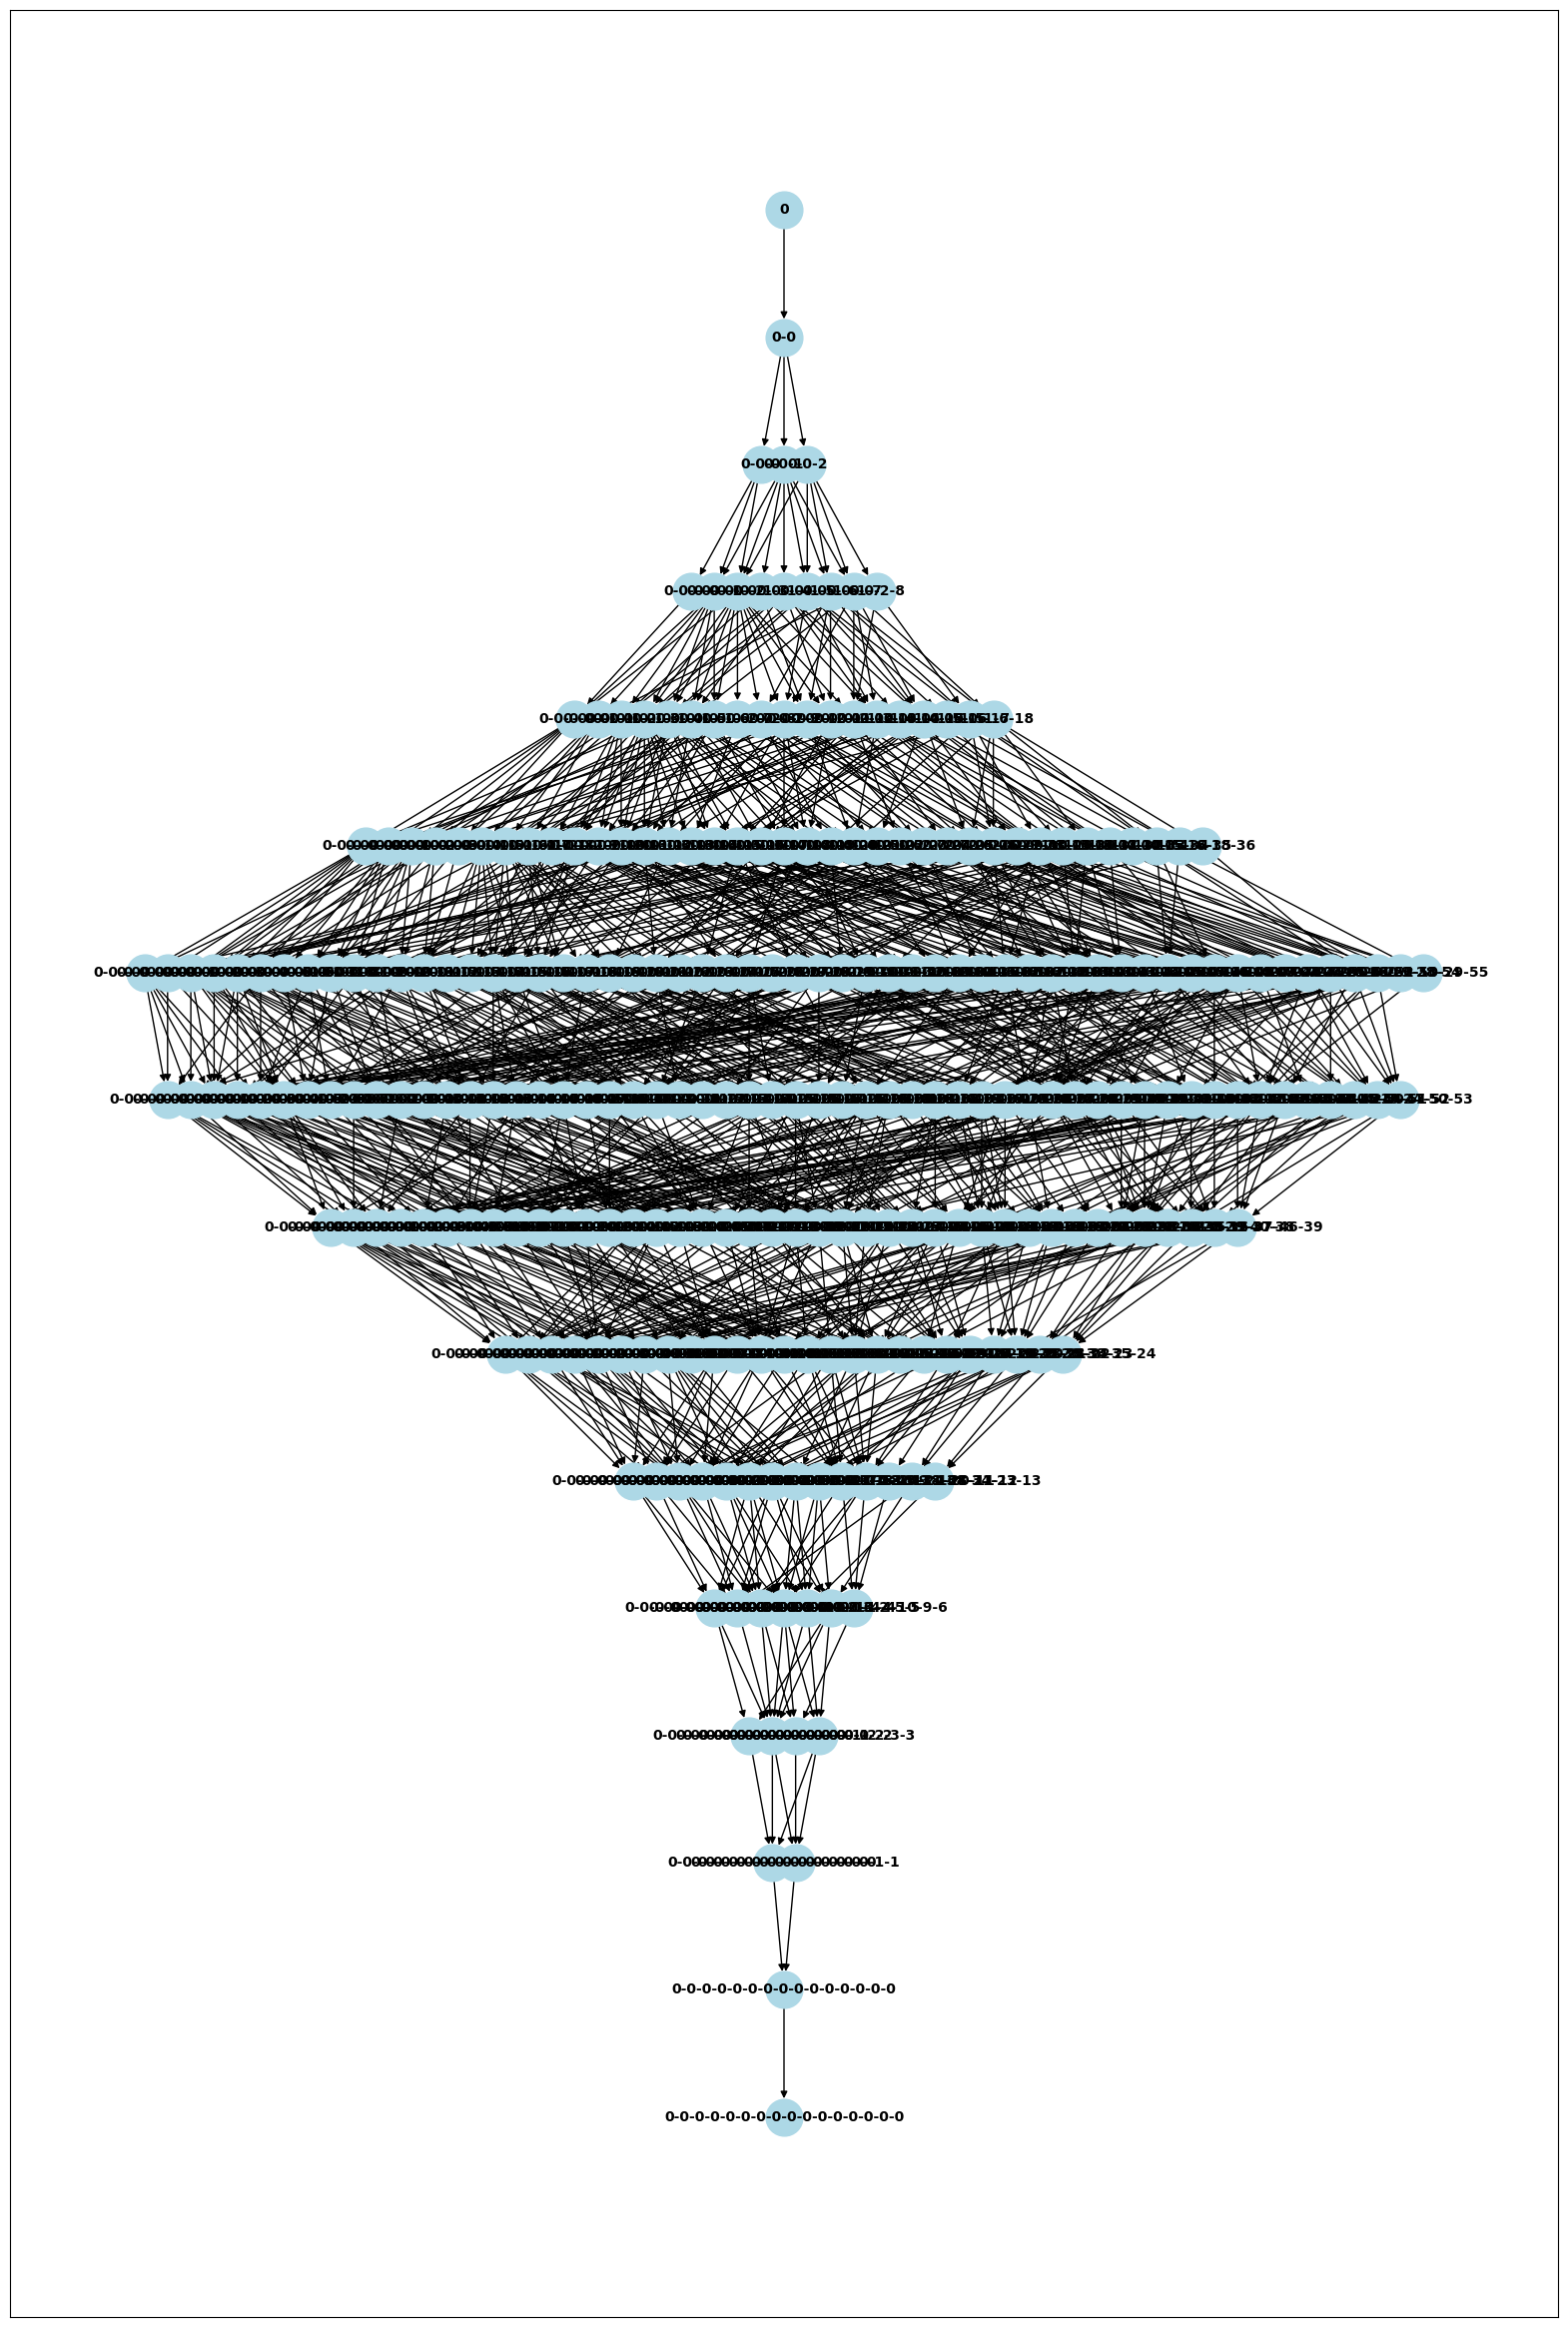

In [27]:
positions = calculate_positions(P)
plt.figure(figsize=(20, 30))
nx.draw_networkx(P, pos=positions, with_labels=True, node_size=700, node_color="lightblue", font_size=10, font_weight="bold")
plt.show()

In [9]:
import json

In [10]:
def graph_to_json_structure(G):
    vertices = {}
    pos_dict = nx.spring_layout(G)
    for u in G.nodes():
        vertices[u] = {'position': {'x': pos_dict[u][0],'y': pos_dict[u][1]}}
    
    edges = list(G.edges())
    return {'vertices': vertices, 'edges': edges}


In [28]:
json_data = {'vertices': {}, 'edges': list(P.edges())}
pos = calculate_positions(P)
for node, data in P.nodes(data=True):
    nested_graph = data['graph']
    json_data['vertices'][node] = {
        'position': {
            'x': pos[node][0],
            'y': pos[node][1]
        },
        'associated_graph': graph_to_json_structure(nested_graph)
    }

json_str = json.dumps(json_data, indent=2)
with open('graph_data.json', 'w') as f:
    json.dump(json_data, f, indent=2)